# Text Analytics Demonstration by Jonathan Janke

This document explains how to extract meaning from text in order to classify it into predefined categories. The code uses strategies from Machine Learning and Natural Language Processing.

The text corpus is taken from the **per-category files** from http://jmcauley.ucsd.edu/data/amazon/links.html. The text corpus is reviews from Amazon. The goal of the algorithm is to detect the category that a given review belongs to.

Four product categories were chosen for simplification of analysis: Amazon Instant Video, Musical Instruments, Baby, Patio Lawn and Garden. Thus, these are the categories to be detected by the algorithm.

Starting with importing the necessary packages. It is preferable to import all necessary packages at the beginning rather than loading packes later on. Thus all the necessary packages are imported in this initial block.

In [1]:
import json
import pickle
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import copy
import collections

from re import compile, sub

import unidecode
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize as wt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import pdb
from sklearn.model_selection import train_test_split
from features.process_text.tokenization import word_tokenize, ngrams_tokenize, vocabulary_size
from sklearn import svm
from sklearn.metrics import confusion_matrix

In [2]:
% matplotlib inline

This program is not primarily focused on efficiency since it does not have to be reloaded a lot. Once the data is loaded once and the model is trained, it will rarely be necessary to do so again. 

Firstly, the data loading process could be optimised since we only need to read in 100000 lines of the data.
Secondly, the data is afterwards stored in dictionaries of the form {dataset: data}. This could be stored more efficiently by encoding the dataset with a number within the data.

Before starting with the data gathering, it is helpful to define some helper functions. These will be used throughout the program and are most self-explanatory:
- save_data enables saving the data to a defined output file (picke format). This enables us to export the cleaned data such that we do not need to do so again
- load_data enables us to retrieved the previously saved data (from a pickle file)
- apply_on_dict, apply_on_list, apply_on_real_list: As stated above, the data is stored in dictionaries of {datasource:data}. The values within these dictionaries are pandas dataframes. Within these pandas dataframes, values will later be stored in lists [e. g. tokenized text]. Every data transformation will need to be applied on all datasets and on all entries. These three functions enable code efficient looping through these data structures to apply functions to them.

The functions are not implemented the most pythonic way. If I was to reimplement the method, I would use \*args or even some \*kwargs

In [3]:
def save_data (dictionary, file_identifier, include_timestamp = True):

    now = datetime.datetime.now()
    prefix = ""
    if include_timestamp: prefix = now.strftime("%Y%m%d_%H%M_")
    with open('data/output/' + prefix + file_identifier + '.pickle', 'wb') as handle:
        pickle.dump(dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
def load_data (file_name):
    with open('data/output/' + file_name + ".pickle", 'rb') as handle:
        return pickle.load(handle)

In [5]:
def apply_on_dict(data_input_, func, params = []):
    data_input = copy.deepcopy(data_input_)
    for key in data_input.keys():
        l_text = data_input[key]
        temp = func(l_text, *params)
        pdb.set_trace
        data_input[key] = temp
    return data_input

In [6]:
def apply_on_list(list_data, func, params = []):
    for index, row in list_data.iteritems():
        list_data.loc[index] = func(row, *params)
    return list_data

In [7]:
def apply_on_real_list(list_data, func, params = []):
    for row_ind in range(len(list_data)):
        list_data[row_ind] = func(list_data[row_ind], *params)
    return list_data

## Data Gathering

The data gathering step describes the process of reading in the data from the hard drive, subsampling it and performing some initial analysis on it.

The data is read from json files in a local folder of the project. The files to read are defined by the list below.

In [8]:
data_sources = ["reviews_Amazon_Instant_Video.json","reviews_Musical_Instruments.json", "reviews_Baby.json", "reviews_Patio_Lawn_and_Garden.json"]

This part drops the ".json" part from the filenames, so the names are nicer to read.

In [9]:
source_name = [name.split("reviews_")[1].split(".")[0] for name in data_sources]

Initially, the data is read in json format in a pandas data frame. After the first time, when the data sources were loaded ones and subsample, this process will be omitted by reading in from pickle files of data subsamples (as described below).

In [ ]:
# ALT1:
data_json = [{source_name: pd.read_json("data/" + data_source, lines=True)} for data_source,source_name in zip(data_sources, source_name)]

The four datasets will be stored in a dictionary for the preprocessing part. Furthermore, the data is subsampled to only contain 100000 comments per dataset. The dictionaries will be of the form {source_name:source_content} for all sources

In [10]:
data_review = {source_name[i]:data_json[i][source_name[i]]["reviewText"][0:100000] for i  in range(len(data_json))}

As described above, an alternative to loading the all of the files and subsampling is reading the prepared dictionaries from the hard drives. This step assumes that the data has been saved in the desired format before. For the example below, a file with the name "20180421_1219_initial_data_filtered.pickle" needs to be stored.

In [9]:
# # ALT2:
data_review = load_data("20180421_1219_initial_data_filtered")

In [73]:
# data_review = {key: value[0:100] for key,value in zip(data_review.keys(), data_review.values())}

We can look at the data to get a general understanding of the data. This gives us a general notion of what the dataset looks like. We can see that the comments talk about topics like "South Park" and "cartoon series". This already gives us a notion of how these Amazon Instant Video comments look like and what they talk about.  

In [74]:
data_review["Amazon_Instant_Video"].head()

0    CA Lewsi' review should be removed. he's revie...
1    I truly love the humor of South Park. It's soc...
2    This is a cartoon series pitting eight cartoon...
3    Yeah drawn together is great when it comes to ...
4    Seems like today's generation is getting reven...
Name: reviewText, dtype: object

To load the data in the process above, we need a saved file. This process step saves the data with the name defined below (and adds a date tag).

In [14]:
save_data(data_review, "initial_data_filtered")

To look at some more general notions of the dataset, one can define a function that counts the number of words for each review source. The function works on an entire dictionary and saves the length (number of words) for each comment in the dictionaries.

In [20]:
def count_data (data_review): return {key: np.array([len(l) for l in text]) for text,key in zip(data_review.values(),data_review.keys())}

Then we can count the data for all entries in the dictionary.

In [65]:
data_count = count_data(data_review)

Furthermore, it makes sense to define a function to plot the data count for all data sources, so one can get a visual understanding of how the comment distribution looks like. This visualisation could also be used to perform an outlier filtering, although this step was ommited for this project.

In [21]:
def plot_words(data_count):
    fig, axes = plt.subplots(2,2)
    for i in range(4):
        axes[int(i/2), i%2].plot(data_count[source_name[i]])
        axes[int(i/2), i%2].set_title(source_name[i])
        axes[int(i/2), i%2].set_ylabel("Number of words")
        axes[int(i/2), i%2].set_xlabel("Entry #")
    fig.tight_layout()
    plt.show()

And plot all four data sources...

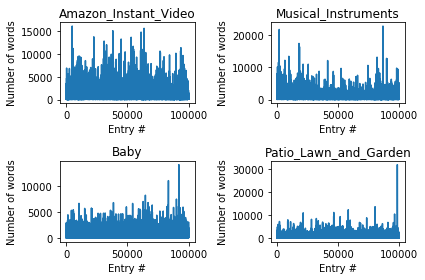

In [66]:
plot_words(data_count)

## Data Preprocessing

Data Preprocessing is about preparing the textual data to eventually perform numerical analysis on it. This step is often referred to as normalisation. Basically, its goal is to ommit parts of speech whose meaning contribute little to the understanding of the sentence. Furthermore, we want to get similar/identical expression in a unified format. The preprocessing step below includes:
- lower case conversion
- contraction replacement
- accent/umlaut treatment
- special character treatment
- end character removal
- stop word removal
- word/sentence tokenization
- lemmatization
- POS tagging

Other possible steps were excluded, e. g. acronym treatment, spelling correction. The reason for this is that acronym replacement requires a predefined lexicon or a pretrained model and spelling correction can likely lead to erroneous results in social media data since spelling rules are often ignored and words are abbreviated in unconventional ways, e. g. "u" instead of "you". Furthermore, spelling correction requires a big text corpus that fits the dataset. This not only adds computational complexity of building a probabilistic word model on the other text corpus but also imposes the difficulty of choosing an adequate corpus that reflects today's speech patterns.

During the following steps, the functions "apply_on_dict", "apply_on_list" and "apply_on_real_list" are leveraged to simplify the preprocessing as described in the introduction above.

### Lower Case Conversion

In [11]:
clean_lower_case = apply_on_dict(data_review, apply_on_list, [str.lower])

In [23]:
clean_lower_case["Amazon_Instant_Video"].head()

0    ca lewsi' review should be removed. he's revie...
1    i truly love the humor of south park. it's soc...
2    this is a cartoon series pitting eight cartoon...
3    yeah drawn together is great when it comes to ...
4    seems like today's generation is getting reven...
Name: reviewText, dtype: object

### Contractions

Contractions are short forms of expressions that are usually made up of multiple abbreviated words. These expressions should be converted to its original words. This step is called contraction expansion and is done with a dictionary. This dictionary contains many possible contractions such that we only need to go through the text corpus and replace their occurences by their expanded counterparts.

In [13]:
CONTRACTION_DICT = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

To find the contractions in the text, one can use a regular expression as below:

In [14]:
c_re = compile('(%s)' % '|'.join(CONTRACTION_DICT.keys()))

One can define a function that can be applied on text strings to expand all contractions.

In [15]:
def expandContractions(text, c_re=c_re):
    def replace(match):
        return CONTRACTION_DICT[match.group(0)]
    return c_re.sub(replace, text)


The above defined function is then applied on the whole dictionary and on every entry in the pandas dataframe for each dataset.

In [16]:
clean_contractions = apply_on_dict(clean_lower_case, apply_on_list,[expandContractions])

Looking at a sample of the data, one can already see in the first two comments that two contractions were removed at the beginning of the second sentence in both comments. In the first comment, the contraction "He's" was removed with "he is" and in the second comment "It's" was removed with "it is".

In [17]:
clean_contractions["Amazon_Instant_Video"].head()

0    ca lewsi' review should be removed. he is revi...
1    i truly love the humor of south park. it is so...
2    this is a cartoon series pitting eight cartoon...
3    yeah drawn together is great when it comes to ...
4    seems like today's generation is getting reven...
Name: reviewText, dtype: object

### Accents/Umlauts

Accents and umlauts are not common in the English language but some people still use them, e. g. for person names, titles but also words like "naïve" contain umlauts. As people tend to write these words differently, it makes sense to remove them entirely from the text corpus. This is done by converting the text string to unicode.

In [18]:
clean_accents = apply_on_dict(clean_contractions, apply_on_list, [unidecode.unidecode])

In [19]:
clean_accents["Amazon_Instant_Video"].head()

0    ca lewsi' review should be removed. he is revi...
1    i truly love the humor of south park. it is so...
2    this is a cartoon series pitting eight cartoon...
3    yeah drawn together is great when it comes to ...
4    seems like today's generation is getting reven...
Name: reviewText, dtype: object

### Special Chars

The following step is about removing special characters from the text documents. Special characters are characters like "$", "&", "*", "(" etc. These characters usually do not contribute any meaning to the text. Thus, it is advisable to remove these. Nonetheless, some characters should be kept to maintain the corpus structure, e.g. ".", "?", "!" for sentence breaks. To summarize the process below, all characters that are not defined as characters to keep (a...z,0...9,?,!,.) are removed from the text corpus.

In [20]:
def remove_special_chars_from_dict(data_review):
    for key in data_review.keys():
        l_text = data_review[key]
        data_review[key] = remove_special_chars_from_list(l_text)
    return data_review

In [21]:
def remove_special_chars_from_list(l_text, SPECIAL_CHARACTERS = ['$', '&', '*', '%', '(', ')', '~', '-', '"', "'", ',']):
    for text_i in range(len(l_text)):
        processed_text = special_characters_pattern.sub(r' ', l_text[text_i])
        l_text[text_i] = sub(' +', ' ', processed_text)
    return l_text

def remove_special_chars (l_text, special_characters_pattern):
    processed_text = special_characters_pattern.sub(r' ', l_text)
    return sub(' +', ' ', processed_text)

In [22]:
def show_individual_characters (l_text):
    return list(set([letter for text in l_text for word in text for letter in word]))

In [23]:
def show_individual_characters_2 (l_text):
    return list(set([letter for word in l_text for letter in word]))

In [24]:
clean_copy = copy.deepcopy(clean_accents)

In [25]:
ind_words_dict = apply_on_dict(clean_copy, apply_on_list, [show_individual_characters_2])

In [26]:
ind_words = set([letter for dic in ind_words_dict.values() for row in dic for letter in row])

In [27]:
# make this a regex
legal_chars = [".", "?", "!", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "a","b","c","d","e","f","g","h", "i", "j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"]

In [28]:
ind_words_np = np.array([word for word in ind_words])
legal_chars_np = np.array(legal_chars)

In [29]:
char_filter = [not np.isin(word, legal_chars_np) for word in ind_words_np]

In [30]:
SPECIAL_CHARACTERS = ind_words_np[char_filter]
special_characters_literal = ['\\' + character for character in SPECIAL_CHARACTERS]
special_characters_pattern = compile('[{}]'.format(''.join(special_characters_literal)))        

In [31]:
clean_special_chars = apply_on_dict(clean_accents, apply_on_list, [remove_special_chars, [special_characters_pattern]])

Looking at the dataframe below, one can see that the data already looks a lot cleaner and has no more unnecessary special characters.

In [32]:
clean_special_chars["Amazon_Instant_Video"].head()

0    ca lewsi review should be removed. he is revie...
1    i truly love the humor of south park. it is so...
2    this is a cartoon series pitting eight cartoon...
3    yeah drawn together is great when it comes to ...
4    seems like today s generation is getting reven...
Name: reviewText, dtype: object

### Sentence Tokenization

Sentence Tokenization is about splitting the text document into multiple sentences. This is not as trivial as breaking at every ".","?","!" but requires a more solely understanding of the text to avoid breaking at occurences of these characters within the text. 

We use the sent_tokenize method from nltk and apply it on every entry in the dataframe for every dictionary in our document collection.

In [33]:
# split into sentences
clean_sentence_tokenized = apply_on_dict(clean_special_chars, apply_on_list, [sent_tokenize])

The final document is similar to what it looked before but the list of comments is now subdivided into lists of sentences.

In [34]:
clean_sentence_tokenized["Amazon_Instant_Video"][1]

['i truly love the humor of south park.',
 'it is social political commentary and satirical wit and bathroom absurdity rules.',
 'no holds barred!',
 'i live to breathe another day in anticipation of trey parker s next installment whether it be south park or some other venture.',
 'south park is truly the work of a genius.',
 'thank you sir parker.',
 'in britian they often knight certian individuals usually after they are old or dead for their contributions to their society sometimes it is dry.',
 'sometimes it is wet.',
 'and sometimes it is too moist for humor.',
 'but somebody has to do it!i would like to see new south park episodes until the day i leave this mortal existence.',
 'however i know that sir parker would want to move on .',
 'however i would much like to see south park from the eyes of a 90 year old trey parker.',
 'what wisdom would we see then?....']

### Word Tokenization

The same procedure from sentence tokenization can be applied on words. This process ends up creating a nested list structure of our document collection containing multiple documents, which contain multiple comments, which themselves contain multiple sentences made up of multiple words. Thus, we have a very nested structure with individual words at its core.

In [48]:
# split into words
clean_word_tokenized = apply_on_dict(clean_sentence_tokenized, apply_on_list, [apply_on_real_list, [wt]])

In [49]:
clean_word_tokenized["Amazon_Instant_Video"][1]

[['i', 'truly', 'love', 'the', 'humor', 'of', 'south', 'park', '.'],
 ['it',
  'is',
  'social',
  'political',
  'commentary',
  'and',
  'satirical',
  'wit',
  'and',
  'bathroom',
  'absurdity',
  'rules',
  '.'],
 ['no', 'holds', 'barred', '!'],
 ['i',
  'live',
  'to',
  'breathe',
  'another',
  'day',
  'in',
  'anticipation',
  'of',
  'trey',
  'parker',
  's',
  'next',
  'installment',
  'whether',
  'it',
  'be',
  'south',
  'park',
  'or',
  'some',
  'other',
  'venture',
  '.'],
 ['south', 'park', 'is', 'truly', 'the', 'work', 'of', 'a', 'genius', '.'],
 ['thank', 'you', 'sir', 'parker', '.'],
 ['in',
  'britian',
  'they',
  'often',
  'knight',
  'certian',
  'individuals',
  'usually',
  'after',
  'they',
  'are',
  'old',
  'or',
  'dead',
  'for',
  'their',
  'contributions',
  'to',
  'their',
  'society',
  'sometimes',
  'it',
  'is',
  'dry',
  '.'],
 ['sometimes', 'it', 'is', 'wet', '.'],
 ['and', 'sometimes', 'it', 'is', 'too', 'moist', 'for', 'humor', '.'

### Remove end characters

Having split the documents into its sentences and words, keeping the end characters is no longer necessary because we don't need them to detect our document structure. This process removes the remaining characters that we kept during the special char process above. Specifically, this means removing all "?", ".", "!".

In [50]:
def remove_end_characters (text):
    END_CHARACTERS = ['.', '?', '!']
    end_characters_literal = ['\\' + character for character in END_CHARACTERS]
    end_characters_pattern = compile('[{}]+'.format(''.join(end_characters_literal)))
    return [word_token for word_token in text if not end_characters_pattern.match(word_token)]

In [51]:
clean_end_chars = apply_on_dict(clean_word_tokenized, apply_on_list, [apply_on_real_list, [remove_end_characters]])

In [52]:
clean_end_chars["Amazon_Instant_Video"][1]

[['i', 'truly', 'love', 'the', 'humor', 'of', 'south', 'park'],
 ['it',
  'is',
  'social',
  'political',
  'commentary',
  'and',
  'satirical',
  'wit',
  'and',
  'bathroom',
  'absurdity',
  'rules'],
 ['no', 'holds', 'barred'],
 ['i',
  'live',
  'to',
  'breathe',
  'another',
  'day',
  'in',
  'anticipation',
  'of',
  'trey',
  'parker',
  's',
  'next',
  'installment',
  'whether',
  'it',
  'be',
  'south',
  'park',
  'or',
  'some',
  'other',
  'venture'],
 ['south', 'park', 'is', 'truly', 'the', 'work', 'of', 'a', 'genius'],
 ['thank', 'you', 'sir', 'parker'],
 ['in',
  'britian',
  'they',
  'often',
  'knight',
  'certian',
  'individuals',
  'usually',
  'after',
  'they',
  'are',
  'old',
  'or',
  'dead',
  'for',
  'their',
  'contributions',
  'to',
  'their',
  'society',
  'sometimes',
  'it',
  'is',
  'dry'],
 ['sometimes', 'it', 'is', 'wet'],
 ['and', 'sometimes', 'it', 'is', 'too', 'moist', 'for', 'humor'],
 ['but',
  'somebody',
  'has',
  'to',
  'do',


### Remove stop words

Stop words are words that don't contain a lot of meaning, e.g. "and", "or", "the". Especially from a statistical analysis point of view, these words are contained in many corpora without having a distinguishing character for any corpora. Thus, running statistical analysis on those would not lead to any good results which is why it makes sense to remove them from the corpora.
There are collections for several common stopwords for multiple languages available. Choosing the stopwords from English, we can remove all stopword from our word lists.

In [53]:
def remove_stop_words (text):
    return [word_token for word_token in text if word_token not in stopwords.words('english')]

In [55]:
clean_end_chars = apply_on_dict(clean_end_chars, apply_on_list, [apply_on_real_list, [remove_stop_words]])

This leads to the word list below. This list should only contain words that determine the meaning of the comments and help distinguish these comments' categories from other categories'

In [58]:
clean_end_chars["Amazon_Instant_Video"].head()

0    [[ca, lewsi, review, removed], [reviewing, epi...
1    [[truly, love, humor, south, park], [social, p...
2    [[cartoon, series, pitting, eight, cartoon, st...
3    [[yeah, drawn, together, great, comes, crude, ...
4    [[seems, like, today, generation, getting, rev...
Name: reviewText, dtype: object

Furthermore, it can make sense to remove all further words that  are shorter than a predefined length threshold. In this case, this process is not applied since the domain knowledge is available that for the instant video category category, the words "cd" and dvd" are very common. These would likely be removed in the process described.

### Lemmatization

Lemmatization is chosen to get the original form of the words in the documents. This is a form of normalization such that statistics more accurately represent word occurences. Here, lemmatization is chosen instead of stemming for this normalisation because lemmatization is usually more accurate. Stemming oftentimes leads to hardly interpretable word forms and does not work on special word forms, e. g. see, saw seen.

In [59]:
clean_lemmatized = apply_on_dict(clean_end_chars, apply_on_list, [apply_on_real_list, [apply_on_real_list, [WordNetLemmatizer().lemmatize]]])

In [60]:
clean_lemmatized["Amazon_Instant_Video"].head()

0    [[ca, lewsi, review, removed], [reviewing, epi...
1    [[truly, love, humor, south, park], [social, p...
2    [[cartoon, series, pitting, eight, cartoon, st...
3    [[yeah, drawn, together, great, come, crude, h...
4    [[seems, like, today, generation, getting, rev...
Name: reviewText, dtype: object

In [61]:
data_cleaned = copy.deepcopy(clean_lemmatized)

In [62]:
save_data (data_cleaned, file_identifier="cleaned_data")

### POS tagging

POS tagging enables understanding the corpus and its components. It assigns a tag from the Penn Treebank tagset to every word in the corpus. It enables filtering on specific parts of speech for a more detailed analysis. For example, this example will later train a classifier only on nouns in the corpus. These nouns are found thanks to the POS tagger. Furthermore, these tags help to verify that the preprocessing activities were conducted successfully.

In [63]:
clean_tagged = apply_on_dict(clean_lemmatized, apply_on_list, [apply_on_real_list, [pos_tag]])

One confirmation that the data preprocessing was conducted successfully is that we only see the tag "NN" in our words and rarely find other noun forms. This means that the other noun forms were mostly well normalized to its stem.

In [64]:
clean_tagged["Amazon_Instant_Video"][10]

[[('adult', 'NN'),
  ('humor', 'NN'),
  ('cutting', 'VBG'),
  ('sarcasm', 'JJ'),
  ('dry', 'JJ'),
  ('take', 'NN'),
  ('reality', 'NN'),
  ('show', 'NN'),
  ('least', 'JJS')]]

In [65]:
save_data (clean_tagged, file_identifier="clean_tagged")

The following two lines are not relevant to understand the process but they are used to recreate earlier preprocessed documents such that this resource-consuming process does not have to be repeated.

In [10]:
data_tagged = load_data(file_name="20180428_1933_clean_tagged")
# data_tagged = clean_tagged

In [11]:
data_cleaned = load_data(file_name="20180422_0559_cleaned_data")

As described in the POS introduction, it makes sense to create a subset of the corpus that only contains nouns. We'll do that by using the POS tagged words and filtering every word that does not have the tag "NN".

In [68]:
def get_nouns(word_list):
    noun_list = []
    for word in word_list:
        if word[1]=="NN" or word [1]=="NNS": noun_list.append(word[0])
    return noun_list

In [69]:
data_nouns = apply_on_dict(data_tagged, apply_on_list, [apply_on_real_list, [get_nouns]])

In [70]:
save_data (data_nouns, file_identifier="clean_nouns")

In [12]:
data_nouns = load_data(file_name="20180428_1954_clean_nouns")

In [13]:
len(data_nouns["Amazon_Instant_Video"])

100000

## Data Exploration

The data exploration step is about creating a deeper understanding of the preprocessed data. One can provide some visual insights into the shape of the cleaned textual data as done initially in the step at the beginning of this document. Furthermore, the data exploration step will be used to create different numeric data representations, such as different bag of words and ngram models (absolut, TFIDF-based).

In [13]:
nouns = copy.deepcopy(data_nouns)
data = copy.deepcopy(data_cleaned)

In [14]:
def create_flat_representation_from_comment(comments):
    #pdb.set_trace()
    return [word for sentence in comments for word in sentence]
def create_comment_representation(dict_inp):
    return [[word for sentence in comment for word in sentence] for comment in dict_inp]
def create_flat_representation(dict_inp):
    return [word for sentence in create_comment_representation(dict_inp) for word in sentence]

In [55]:
flat_data = apply_on_dict(data_cleaned, create_flat_representation)
flat_nouns = apply_on_dict(data_nouns, create_flat_representation)

We can plot the length of the sentences for our datasets and look at their distribution. This clearly shows some outliers (not treated here to retain size of dataset).

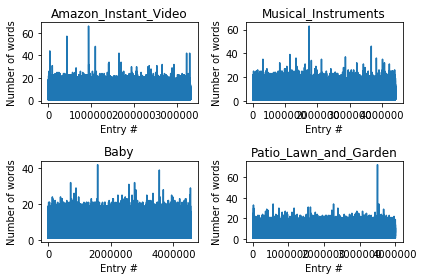

In [57]:
data_count = count_data(flat_data)
plot_words(data_count)

Nonetheless, this meta information is not used for the final classifier, because the intention is to only base this final classifier on textual inputs.

To actually use the different documents, we need to merge the seperated documents into a single file. To be able to train a classifier to these documents later, we assign a class to each document's comments, such as 0 for Amazon Instant Videos, etc.

In [15]:
comment_data = apply_on_dict(data, create_comment_representation)
comment_nouns = apply_on_dict(nouns, create_comment_representation)

In [16]:
def create_prediction_data(inp_data, inp_nouns):
    prediction_data = []
    prediction_nouns = []
    y=[]
    class_index = 0
    for key in inp_data.keys():
        # pdb.set_trace()
        temp = ([" ".join(da) for da in inp_data[key]])
        # pdb.set_trace()
        # temp = " ".join(temp)
        prediction_data.extend(temp)
        prediction_nouns.extend([" ".join(da) for da in inp_nouns[key]])
        y.extend([class_index for da in inp_nouns[key]])
        class_index += 1
    return prediction_data, prediction_nouns, y

In [17]:
c_data, c_nouns,y = create_prediction_data(comment_data, comment_nouns)

In [18]:
xd_train, xd_test, xn_train, xn_test, y_train, y_test = train_test_split(c_data, c_nouns, y, test_size=0.3)

In [25]:
xd_train[200]

'people allegedly problem adaptec apparently really called magix solution bought audio cleaning lab installed read negative review called magix talked tech support people alleged problem discussed review said negative review could come 2 group people 1 people cd burner new pertinent driver written group 2 group coincidentally presence direct cd program running background seen pulling list program cntl alt del listing terminate adaptec one program many us direct cd problem since installing using program buyer beware issue user know system issue program good system highly recommend anyone transferring tape cd'

### BOW

The bag of words model is a simple, count-based model that represents statistics within text corpora. It can be done on a simple frequency base or using the term frequency-inverse document frequency (TFIDF). A sparse matrix is created that contains the word count for every possible word for each comment in the document. Since naturally most words don't appear in most of the comments, the matrix contains many empty entries (0).

The initial part of this document is solely exploratory:

In [29]:
from model import collocations

In [30]:
test = apply_on_dict(flat_data, collocations.compute_collocation_bigram)

In [31]:
top10_freq_bigram_collocations =apply_on_dict(test, collocations.get_top_collocations_freq, [10])

In [32]:
print(top10_freq_bigram_collocations)

{'Amazon_Instant_Video': [('love', 'show'), ('great', 'show'), ('story', 'line'), ('year', 'old'), ('season', '1'), ('first', 'season'), ('season', '2'), ('one', 'best'), ('tv', 'show'), ('season', '3')], 'Musical_Instruments': [('would', 'recommend'), ('sound', 'great'), ('work', 'great'), ('work', 'well'), ('sound', 'quality'), ('highly', 'recommend'), ('sound', 'like'), ('sound', 'good'), ('year', 'old'), ('well', 'made')], 'Baby': [('month', 'old'), ('year', 'old'), ('car', 'seat'), ('would', 'recommend'), ('highly', 'recommend'), ('easy', 'use'), ('easy', 'clean'), ('work', 'great'), ('6', 'month'), ('high', 'chair')], 'Patio_Lawn_and_Garden': [('work', 'great'), ('work', 'well'), ('easy', 'use'), ('would', 'recommend'), ('highly', 'recommend'), ('year', 'ago'), ('well', 'made'), ('1', '2'), ('put', 'together'), ('great', 'product')]}


In [33]:
top10_pmi_bigram_collocations = apply_on_dict(test, collocations.get_top_collocations_pmi, [10])

In [34]:
print(top10_pmi_bigram_collocations)

{'Amazon_Instant_Video': [('000.with', 'unrivalled'), ('1.1', 'pilotas'), ('1.season', '42.season'), ('1000.the', 'badkilling'), ('10h', '7m'), ('114width', '142height'), ('12398', '12503'), ('12450', '12531'), ('12451', '12450'), ('12472', '12455')], 'Musical_Instruments': [('0.29b', '0.36g'), ('0.36g', '0.58d'), ('0.500', 'inch.update'), ('0.58d', '0.71a'), ('0.71a', '0.97e'), ('0.97e', '1.19'), ('0001', '0002'), ('00801m', 'antimicrobial'), ('0095', '0115'), ('00allan', 'pettersson14')], 'Baby': [('0209a', '0210a'), ('0210a', '02720'), ('02720', 'hk1100aae4bmjs'), ('0312258', '2784138'), ('1.0', 'togwhich'), ('1.good', 'quality2.comfortable3.useful'), ('10409', 'andmommy'), ('1100c.a', 'krueger'), ('12yrs', 'old.only'), ('130am', '730am')], 'Patio_Lawn_and_Garden': [('0.039kg', '39g'), ('0.41', '0.51'), ('0.46', 'ft3'), ('0.4ml', '46lb'), ('0.81', '2090'), ('0.final', 'tally'), ('003', '040105'), ('012', '3117'), ('0222', 'tachometer'), ('02yt202', '1in')]}


The following part is used to create the bag of words that will then be used for the classifier. This bag of words model is entirely word frequency based without normalisation.

In [ ]:
bow_train, bow_vectorizer = word_tokenize(xd_train)  # data.data = data_lst.tolist()

In [ ]:
bow_test = bow_vectorizer.transform(xd_test)

In [37]:
print('Vocabulary size (bow): '+str(vocabulary_size(bow_vectorizer)))

Vocabulary size (bow): 144426


In [38]:
print(bow_vectorizer.get_feature_names()[20000:20010])

['birkenstocks', 'birkey', 'birki', 'birkies', 'birks', 'birman', 'birmingham', 'birned', 'birney', 'birp']


In [58]:
bow_vectorizer.transform(xn_train)

<280000x144426 sparse matrix of type '<class 'numpy.int64'>'
	with 4196694 stored elements in Compressed Sparse Row format>

### BOW NOUN

An identical Bag of words matrix is created for the noun-filtered dataset.

In [ ]:
bow_noun_train, bow_noun_vectorizer = word_tokenize(xn_train)

In [ ]:
bow_noun_test = bow_noun_vectorizer.transform(xn_test)

In [41]:
print('Vocabulary size (bow): '+str(vocabulary_size(bow_noun_vectorizer)))

Vocabulary size (bow): 95530


In [42]:
bow_noun_vectorizer.transform(xn_train)

<280000x95530 sparse matrix of type '<class 'numpy.int64'>'
	with 4196694 stored elements in Compressed Sparse Row format>

### Bigram

Furthermore, we will look into the bigrams in the text. Bigrams are two-word combinations that occur in the text. Similarly to the single-word based Bag of words model, we can count the frequency of the bigrams for every sentence and create a sparse bigram frequency matrix.

The initial part of this report is solely for exploration of some bigrams that can be found in the data.

In [43]:
def combine(text_list):
    text = []
    for tl in text_list:
        text += tl # [0]
    return text

In [44]:
def create_n_gram(text, n=2):
    n_grams = []
    for t in range(len(text)-1):
        ngrams.append((text[t],text[t+1]))
    

In [59]:
bigrams = apply_on_list(data_cleaned["Amazon_Instant_Video"],combine)


In [60]:
bigrams = combine(data_cleaned["Amazon_Instant_Video"])

The second part is about creating the bigram matrix for later analysis.

In [ ]:
bigram_train, bigram_vectorizer = ngrams_tokenize(xd_train, 1, 2)

In [ ]:
bigram_test = bigram_vectorizer.transform(xd_test)

In [64]:
print('Vocabulary size (bigrams): '+str(vocabulary_size(bigram_vectorizer)))
perc = round(float(vocabulary_size(bigram_vectorizer)*100)/vocabulary_size(bow_vectorizer), 2)
print('Bigrams vocabulary size is '+str(perc)+'% larger than bow')

Vocabulary size (bigrams): 4244362
Bigrams vocabulary size is 2938.78% larger than bow


In [65]:
print(bigram_vectorizer.get_feature_names()[1000:1010])

['00 might', '00 mind', '00 mine', '00 mini', '00 minute', '00 mistake', '00 mm', '00 mne', '00 mobile', '00 model']


### TFIDF BOW

We'll create identical matrixes to the BOW models above just with normalised TFIDF values instead of absolute counts. The shape of these matrices will be identical.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [20]:
count_vect = CountVectorizer()
bow_tfidf_transformer = TfidfTransformer()
X_train_counts = count_vect.fit_transform(xd_train)
X_test_counts = count_vect.transform(xd_test)
bow_tfidf_train = bow_tfidf_transformer.fit_transform(X_train_counts)
bow_tfidf_test = bow_tfidf_transformer.transform(X_test_counts)

### TFIDF NOUN BOW

In [21]:
count_vect = CountVectorizer()
bow_noun_tfidf_transformer = TfidfTransformer()
X_train_counts = count_vect.fit_transform(xn_train)
X_test_counts =  count_vect.transform(xn_test)
bow_noun_tfidf_train = bow_noun_tfidf_transformer.fit_transform(X_train_counts)
bow_noun_tfidf_test = bow_noun_tfidf_transformer.transform(X_test_counts)

### TFIDF BIGRAM

In [22]:
count_vect = CountVectorizer()
bigram_tfidf_transformer = TfidfTransformer()
tfidf_bigram_train, tfidf_bigram_vectorizer = ngrams_tokenize(xd_train, 1, 2)
tfidf_bigram_test = tfidf_bigram_vectorizer.transform(xd_test)
bigram_tfidf_train = bigram_tfidf_transformer.fit_transform(tfidf_bigram_train)
bigram_tfidf_test = bigram_tfidf_transformer.transform(tfidf_bigram_test)

### Singular Value Decomposition

The resulting matrices from the steps above are very large, e.g. of the size 300000x88425. This large matrix with 88425 features is very complex for a machine learning model, because the model has to learn on many features. This difficulty is amplified by the fact that the matrix is extremly sparse and thus training data is raw.
To avoid this shortcoming, one can perform singular value decomposition on the data. Singular value decomposition is a method that enables us to reconstruct a large matrix from its eigenvectors and eigenvalues. This is a form of dimensionality reduction and is done in such a matter, that the new eigenvectors cover as much of the original variance as possible, similarly to PCA.

For every model above, we will remove the dimensionality to 100 components.

In [23]:
from sklearn.decomposition import TruncatedSVD

In [24]:
preprocessed_representations = [bigram_tfidf_train, bow_noun_tfidf_train, bow_tfidf_train]

Looking at our transformed files, we can confirm that we have sparse matrices with 280000 rows each. This is equivalent to 70% of the initial data. Furthermore, we can see that the bag of words for the noun filtered data are smaller than the corresponding ones for the whole corpora.

In [25]:
preprocessed_representations

[<280000x4245067 sparse matrix of type '<class 'numpy.float64'>'
 	with 20751253 stored elements in Compressed Sparse Row format>,
 <280000x95925 sparse matrix of type '<class 'numpy.float64'>'
 	with 4202547 stored elements in Compressed Sparse Row format>,
 <280000x144948 sparse matrix of type '<class 'numpy.float64'>'
 	with 9472062 stored elements in Compressed Sparse Row format>]

In [26]:
svd_models = []
svd_results = []
for rep in preprocessed_representations:
    model = TruncatedSVD(n_components=50, n_iter=5, random_state=42)
    svd_results.append(model.fit_transform(rep))
    svd_models.append(model)

In [ ]:
save_data(svd_models,"SVD_MODELS")
save_data(svd_results,"SVD_RESULTS")

### Feature Selection

From the 50 features per dataset created above, we will further reduce the dimensionality to 5 features per document. We will use the ANOVA f-value to determine which features to keep.

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

In [28]:
svd_feat_selected = []
svd_feat_model = []
for res in svd_results:
    svd_feat = SelectKBest(f_classif, k=5)
    temp = svd_feat.fit_transform(res, y_train)
    svd_feat_selected.append(temp)
    svd_feat_model.append(svd_feat)

## Model Development

For the model development, this example uses a simple SVM model from sklearn with linear kernel and the penalty parameter C of the error term with the default value of 1.0.

In [29]:
clf_models  = []

for svd in svd_feat_selected:
    clf = svm.SVC()
    clf.fit(svd, y_train)
    clf_models.append(clf)
    print(clf.score(svd, y_train))
    print(confusion_matrix(y_train, clf.predict(svd)))

0.789078571429
[[63171  3080   512  2933]
 [ 3565 48768  1785 16070]
 [  880  3278 51931 14042]
 [ 1770  6775  4368 57072]]
0.75335
[[58645  2518   962  7571]
 [ 2817 45393  2813 19165]
 [  408  2702 50608 16413]
 [ 1589  6283  5821 56292]]
0.79335
[[63667  3058   589  2382]
 [ 3904 50974  2570 12740]
 [  711  3669 52559 13192]
 [ 1877  6536  6634 54938]]


## Model Validation

The last part of the project is about validating the produced model by scoring it on the test set. What is important here is that all the transformations previously performed need to be done on the test data as well.

In [30]:
test_representations = [bigram_tfidf_test, bow_noun_tfidf_test, bow_tfidf_test]

In [31]:
transformed_rep = []
for ind, rep in enumerate(test_representations):
    # svd
    svd = svd_models[ind].transform(rep)
    # feature selection
    fs = svd_feat_model[ind].transform(svd)
    transformed_rep.append(fs)
    # svc classification
    print(clf_models[ind].score(fs, y_test))
    # confusion matrix
    print (confusion_matrix(y_test, clf_models[ind].predict(fs)))

0.790491666667
[[27241  1461   325  1277]
 [ 1480 20787   949  6596]
 [  311  1361 22864  5333]
 [  706  2972  2370 23967]]
0.75425
[[25376  1114   449  3365]
 [ 1220 19365  1238  7989]
 [  175  1176 21623  6895]
 [  635  2744  2490 24146]]
0.793633333333
[[27616  1336   287  1065]
 [ 1716 21570  1123  5403]
 [  302  1491 22540  5536]
 [  771  2900  2834 23510]]


## Model Evaluation

The three models perform well, scoring between 75% and 80%. The SVM model well reflects the underlying data structure and there is no sign of overfitting in any of the models. All three models score equivilantely well on training and on test data. Nonetheless, this gives rise to the presumption, that we could achieve a better performance with a different model.

We can observe that the models trained on the whole dataset performed a little better (~4 %) than the one that was only trained on the nouns. This leads to the assumption that other non-noun words are relevant for specific topics.

Evaluating the confusion matrix, we can clearly see that the diagonal ones (True Positives) outweigh the other matrix entries. This obviously reflects the model accuracy score. But we can see that the model did particularly well for some classes, while not doing so well for other classes. Interestingly, these patterns are consistent throughout the data. The model seems to be very good between differentiating between classes 0 and 2 (Amazon Instant Video vs. Baby). For example, on the test dataset the BOW classifier on all words classified 302 comments falsely to be about videos although being about babys while only 287 were classified as being about babys while being about videos. These numbers may seem high in absolute terms but they reflect a very good model performance in relative terms. Contrarily, the model seems to have some problems with predicting class 3 (Patio Lawn and Garden). On the test dataset, the model misclassified over 5000 comments as being part of classes 1 or 2 (Musical Instruments/Baby) using the BOW classifier. The other classifiers were even worse in this category. This either shows that the current model is not really fit to reflect the underlying notion of Patio Lawn and Garden comments or that these comments themselves are not very distinctive.

The created model is a rather simple model and more emphasis was put on the data preprocessing and transformation of textual data to text data. If I was to create a more accurate classifier, I would probably choose more advanced models, both for transforming the textual data into a numeric format and to analyze the numeric. I would probably attempt to integrate neural network for both (word2vec, feedforward neural network for classification).

Six different formats of transformations for the same text corpus were presented: Bag of words, bag of words on nouns only, bigrams, bag of words using TFIDF, bag of words on nouns only using TFIDF, bigrams using TFIDF.

The preprocessing was done extensively. Nonetheless, some parts were left out. I think, the model could be more accurate if we had a way of transforming the rather casual language of these comments into a common word form, e.g. by finding acronyms, applying spelling correction etc. These steps were mainly not done due to computational restrictions.

Although the workflow was built on a subsample of the data, it required significant computational power to build the final model with 400.000 data points. In my opinion, it would make more sense to perform the analysis on less data. This would neither significantly worsen the model nor have any other implications.